In [1]:
# !pip install pandas scikit-learn xgboost matplotlib seaborn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report, confusion_matrix


In [2]:
social_url = "https://docs.google.com/spreadsheets/d/1nljJ7XmuYEyqJOkyg_NH5EYcThQyGz-8ScoQRiyDST8/export?format=csv"
transactions_url = "https://docs.google.com/spreadsheets/d/1oyJFciFnlS0ueOg8wQaANRp1JOy8JdbCcglAtVEYcVM/export?format=csv"

transactions = pd.read_csv(transactions_url)
social = pd.read_csv(social_url)

print("Transactions shape:", transactions.shape)
print("Social shape:", social.shape)
transactions.head()
social.head()

Transactions shape: (150, 6)
Social shape: (155, 5)


,customer_id_new,social_media_platform,engagement_score,purchase_interest_score,review_sentiment
0,A178,LinkedIn,74,4.9,Positive
1,A190,Twitter,82,4.8,Neutral
2,A150,Facebook,96,1.6,Positive
3,A162,Twitter,89,2.6,Positive
4,A197,Twitter,92,2.3,Neutral


In [3]:
# Create a common customer ID for merging by extracting the numerical part from social_customer_id
transactions['customer_id_common'] = transactions['customer_id_legacy'].astype(int)
social['customer_id_common'] = social['customer_id_new'].str.extract('(\d+)').astype(int)

# Perform the inner merge on the common customer ID
merged = pd.merge(transactions, social, on='customer_id_common', how='inner')

# Drop the original and temporary common customer ID columns that are no longer needed after merging
merged = merged.drop(['customer_id_legacy', 'customer_id_new', 'customer_id_common'], axis=1, errors='ignore')

print("Merged data shape:", merged.shape)
merged.head()

Merged data shape: (219, 9)


<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1238823152.py:3: SyntaxWarning: invalid escape sequence '\d'
  social['customer_id_common'] = social['customer_id_new'].str.extract('(\d+)').astype(int)


,transaction_id,purchase_amount,purchase_date,product_category,customer_rating,social_media_platform,engagement_score,purchase_interest_score,review_sentiment
0,1001,408,2024-01-01,Sports,2.3,TikTok,61,1.3,Neutral
1,1001,408,2024-01-01,Sports,2.3,Twitter,72,1.6,Neutral
2,1001,408,2024-01-01,Sports,2.3,Twitter,82,3.6,Negative
3,1002,332,2024-01-02,Electronics,4.2,Instagram,60,4.3,Positive
4,1003,442,2024-01-03,Electronics,2.1,Facebook,87,4.8,Negative


In [18]:
merged = merged.drop(['customer_id_legacy', 'customer_id_new', 'transaction_id', 'purchase_date'], axis=1, errors='ignore')

# Remove rows with any missing values
merged = merged.dropna()

# Encode categorical variables
label_encoders = {}
for col in merged.select_dtypes(include=['object']).columns:
    if col != 'product_category':  # don't encode target yet
        le = LabelEncoder()
        merged[col] = le.fit_transform(merged[col])
        label_encoders[col] = le

# Encode the target
target_le = LabelEncoder()
merged['product_category'] = target_le.fit_transform(merged['product_category'])

# Separate features and target
X = merged.drop('product_category', axis=1)
y = merged['product_category']

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(merged.shape)
print(merged['product_category'].value_counts())
merged.head()

(200, 7)
product_category
4    57
2    39
3    38
0    34
1    32
Name: count, dtype: int64


,purchase_amount,product_category,customer_rating,social_media_platform,engagement_score,purchase_interest_score,review_sentiment
0,408,4,2.3,3,61,1.3,1
1,408,4,2.3,4,72,1.6,1
2,408,4,2.3,4,82,3.6,0
3,332,2,4.2,1,60,4.3,2
4,442,2,2.1,0,87,4.8,0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
rf_model = RandomForestClassifier(n_estimators=150, random_state=42)
rf_model.fit(X_train, y_train)

# Option 2: XGBoost
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)

# Option 3: Logistic Regression
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:03:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


LogisticRegression(max_iter=500)

In [8]:
models = {
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "Logistic Regression": lr_model
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    loss = log_loss(y_test, y_proba)

    results.append([name, acc, f1, loss])

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1-Score', 'Log Loss'])
print(results_df)

                 Model  Accuracy  F1-Score  Log Loss
0        Random Forest       0.3  0.286937  1.460031
1              XGBoost       0.4  0.371130  1.602632
2  Logistic Regression       0.2  0.153898  1.647670



Classification Report - Random Forest:
              precision    recall  f1-score   support

       Books       0.25      0.14      0.18         7
    Clothing       0.50      0.50      0.50         6
 Electronics       0.17      0.12      0.14         8
   Groceries       0.29      0.25      0.27         8
      Sports       0.29      0.45      0.36        11

    accuracy                           0.30        40
   macro avg       0.30      0.29      0.29        40
weighted avg       0.29      0.30      0.29        40



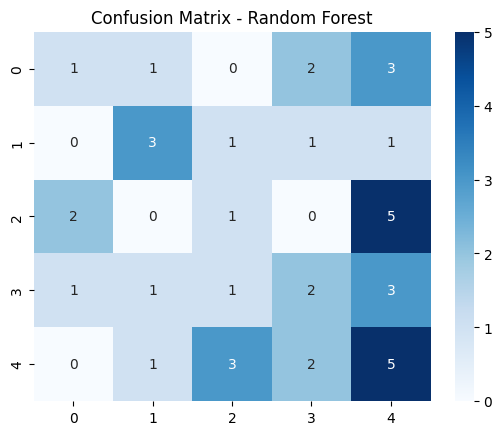


Classification Report - XGBoost:
              precision    recall  f1-score   support

       Books       0.25      0.14      0.18         7
    Clothing       0.60      0.50      0.55         6
 Electronics       0.20      0.12      0.15         8
   Groceries       0.38      0.38      0.38         8
      Sports       0.44      0.73      0.55        11

    accuracy                           0.40        40
   macro avg       0.37      0.37      0.36        40
weighted avg       0.37      0.40      0.37        40



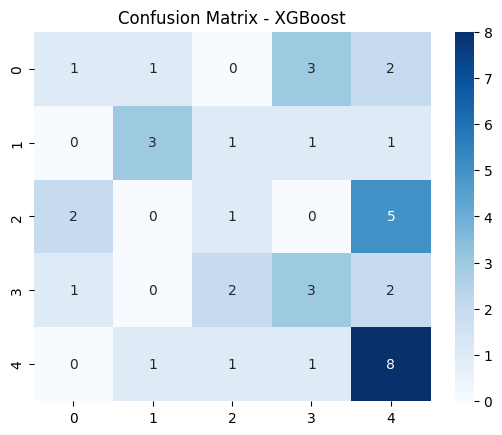

In [12]:
best_model = rf_model  # or choose based on best score
y_pred_best = best_model.predict(X_test)

print('\nClassification Report - Random Forest:')
print(classification_report(y_test, y_pred_best, target_names=target_le.classes_.astype(str)))

sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.show()


# XGBoost Confusion Matrix and Classification Report
y_pred_xgb = xgb_model.predict(X_test)

print('\nClassification Report - XGBoost:')
print(classification_report(y_test, y_pred_xgb, target_names=target_le.classes_.astype(str)))


sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.show()

In [13]:
def recommend_product(model, scaler, target_encoder, feature_columns, customer_features: dict):
       # Convert to DataFrame
    input_df = pd.DataFrame([customer_features])

    # Ensure column order matches training data
    input_df = input_df[feature_columns]

    # Scale numeric features
    input_scaled = scaler.transform(input_df)

    # Predict class
    pred_class = model.predict(input_scaled)[0]

    # Predict probability distribution
    pred_proba = model.predict_proba(input_scaled)[0]

    # Decode label
    predicted_category = target_encoder.inverse_transform([pred_class])[0]

    # Format probabilities nicely
    class_names = target_encoder.classes_
    probabilities = {
        class_names[i]: float(pred_proba[i]) for i in range(len(class_names))
    }

    return predicted_category, probabilities

In [14]:
feature_columns = list(X.columns)

In [15]:
customer_data_1 = {
    "purchase_amount": 120,
    "customer_rating": 5,
    "social_media_platform": 1,  # encoded
    "engagement_score": 0.92,
    "purchase_interest_score": 0.85,
    "review_sentiment": 2        # encoded
}

category, probabilities = recommend_product(
    model=xgb_model,
    scaler=scaler,
    target_encoder=target_le,
    feature_columns=feature_columns,
    customer_features=customer_data_1
)

print("Recommended product:", category)
print("Probabilities:", probabilities)


Recommended product: Electronics
Probabilities: {'Books': 0.0709974393248558, 'Clothing': 0.01897873356938362, 'Electronics': 0.5245794057846069, 'Groceries': 0.014320462942123413, 'Sports': 0.3711239695549011}


In [17]:
customer_data_2 = {
    "purchase_amount": 30,
    "customer_rating": 2,
    "social_media_platform": 0,
    "engagement_score": 0.20,
    "purchase_interest_score": 0.18,
    "review_sentiment": 0
}

category, probabilities = recommend_product(
    model=xgb_model,
    scaler=scaler,
    target_encoder=target_le,
    feature_columns=feature_columns,
    customer_features=customer_data_2
)

print("Recommended product:", category)
print("Probabilities:", probabilities)


Recommended product: Clothing
Probabilities: {'Books': 0.06215638294816017, 'Clothing': 0.5289011597633362, 'Electronics': 0.04871388152241707, 'Groceries': 0.0023476628120988607, 'Sports': 0.3578808903694153}
